In [153]:
"""
WITH fluid_admin AS (
    SELECT
        ie.hadm_id, ie.subject_id, ie.stay_id, ie.itemid, ie.amount, ie.amountuom, ie.ordercategoryname, ie.starttime,
        icu.intime AS icu_admission_time, DENSE_RANK() OVER (PARTITION BY ad.subject_id ORDER BY icu.intime) AS icustay_seq, ad.admittime AS hospital_admission_time
    FROM  `physionet-data.mimiciv_3_1_icu.inputevents` AS ie
    INNER JOIN  `physionet-data.mimiciv_3_1_icu.icustays` AS icu ON ie.subject_id = icu.subject_id AND ie.hadm_id = icu.hadm_id
    INNER JOIN  `physionet-data.mimiciv_3_1_hosp.admissions` AS ad ON ie.hadm_id = ad.hadm_id
    WHERE
        ie.starttime >= ad.admittime -- Fluids administered after hospital admission

),

fluid_admin1 as (
select *
from fluid_admin
where
  icustay_seq=1
  AND ((fluid_admin.starttime > fluid_admin.icu_admission_time) AND (fluid_admin.starttime < TIMESTAMP_ADD(fluid_admin.icu_admission_time, INTERVAL 24 HOUR))) -- Fluids administered after ICU admission
),
fluid_admin2 as ( -- had to do this as a 2-step process otherwise data was messed up across subsequent icu stays
select *
from fluid_admin
where icustay_seq=1 AND starttime < icu_admission_time -- Fluids administered before ICU admission
),
ivf_table AS (
  SELECT DISTINCT stay_id, SUM(amount) AS ivf
  FROM fluid_admin1
  WHERE amount IS NOT NULL
  GROUP BY stay_id
),
norepinephrine AS (
  SELECT stay_id, MAX(norepinephrine_equivalent_dose) as norepinephrine_max
  FROM `physionet-data.mimiciv_3_1_derived.norepinephrine_equivalent_dose`
  GROUP BY stay_id
),
crrt AS (
  SELECT stay_id, MAX(access_pressure) as crrt_access_pressure_max
  FROM `physionet-data.mimiciv_3_1_derived.crrt`
  GROUP BY stay_id
),
fdba AS (
  SELECT stay_id, MIN(pao2fio2ratio_min) as pao2fio2ratio_min, MAX(pao2fio2ratio_max) as pao2fio2ratio_max
  FROM `physionet-data.mimiciv_3_1_derived.first_day_bg_art`
  GROUP BY stay_id
),
first_day_height AS (
  SELECT stay_id, MAX(height) as height
  FROM `physionet-data.mimiciv_3_1_derived.first_day_height`
  GROUP BY stay_id
),
first_day_weight AS (
  SELECT stay_id, MAX(weight) as weight
  FROM `physionet-data.mimiciv_3_1_derived.first_day_weight`
  GROUP BY stay_id
)

SELECT oasis.*,
  fdba.pao2fio2ratio_min,
  fdba.pao2fio2ratio_max,
  pat.gender,
  charlson.*,
  adm.*,
  age.*,
  -- antibiotic.*,
  norepinephrine.*,
  first_day_sofa.*,
  -- complete_blood_count.*,
  --first_day_vitalsign.*,
  first_day_weight.*,
  first_day_height.*,
  ivf_table.*,
  crrt.*
FROM `physionet-data.mimiciv_3_1_derived.oasis` oasis

LEFT JOIN `physionet-data.mimiciv_3_1_hosp.patients` pat
  on oasis.subject_id = pat.subject_id

LEFT JOIN `physionet-data.mimiciv_3_1_derived.charlson` charlson
  on oasis.hadm_id = charlson.hadm_id

left join `physionet-data.mimiciv_3_1_hosp.admissions` adm
  on oasis.hadm_id = adm.hadm_id

LEFT JOIN `physionet-data.mimiciv_3_1_derived.age` age
  on oasis.hadm_id = age.hadm_id

--LEFT JOIN `physionet-data.mimiciv_3_1_derived.antibiotic` antibiotic
--  on oasis.hadm_id = antibiotic.hadm_id

LEFT JOIN norepinephrine
  on oasis.stay_id = norepinephrine.stay_id

LEFT JOIN `physionet-data.mimiciv_3_1_derived.first_day_sofa` first_day_sofa
  on oasis.hadm_id = first_day_sofa.hadm_id

-- LEFT JOIN `physionet-data.mimiciv_3_1_derived.complete_blood_count` complete_blood_count
--   on oasis.hadm_id = complete_blood_count.hadm_id

LEFT JOIN ivf_table
  on ivf_table.stay_id = oasis.stay_id

LEFT JOIN first_day_weight
  on oasis.stay_id = first_day_weight.stay_id

LEFT JOIN first_day_height
  on oasis.stay_id = first_day_height.stay_id

--LEFT JOIN `physionet-data.mimiciv_3_1_derived.first_day_vitalsign` first_day_vitalsign
--  on oasis.stay_id = first_day_vitalsign.stay_id

LEFT JOIN fdba
  on fdba.stay_id = oasis.stay_id

LEFT JOIN crrt
  on oasis.stay_id = crrt.stay_id

WHERE (adm.hospital_expire_flag = 1)
"""

'\nWITH fluid_admin AS (\n    SELECT\n        ie.hadm_id, ie.subject_id, ie.stay_id, ie.itemid, ie.amount, ie.amountuom, ie.ordercategoryname, ie.starttime,\n        icu.intime AS icu_admission_time, DENSE_RANK() OVER (PARTITION BY ad.subject_id ORDER BY icu.intime) AS icustay_seq, ad.admittime AS hospital_admission_time\n    FROM  `physionet-data.mimiciv_3_1_icu.inputevents` AS ie\n    INNER JOIN  `physionet-data.mimiciv_3_1_icu.icustays` AS icu ON ie.subject_id = icu.subject_id AND ie.hadm_id = icu.hadm_id\n    INNER JOIN  `physionet-data.mimiciv_3_1_hosp.admissions` AS ad ON ie.hadm_id = ad.hadm_id\n    WHERE\n        ie.starttime >= ad.admittime -- Fluids administered after hospital admission\n\n),\n\nfluid_admin1 as (\nselect *\nfrom fluid_admin\nwhere \n  icustay_seq=1 \n  AND ((fluid_admin.starttime > fluid_admin.icu_admission_time) AND (fluid_admin.starttime < TIMESTAMP_ADD(fluid_admin.icu_admission_time, INTERVAL 24 HOUR))) -- Fluids administered after ICU admission\n),\nfluid

In [154]:
# --- Importing required libraries and setting global configurations ---

from typing import Dict, Optional, List                   # type hints for dictionaries, optional values, and lists

import numpy as np                                        # numerical computing library for arrays and math
import pandas as pd                                       # data manipulation library for working with DataFrames (tables)
from sklearn.preprocessing import StandardScaler          # scales features to mean=0 and std=1
from sklearn.metrics.pairwise import euclidean_distances  # computes pairwise Euclidean distances between vectors
import matplotlib.pyplot as plt                           # plotting library for creating figures
import seaborn as sns                                     # high-level plotting library built on top of matplotlib
from tqdm.notebook import tqdm                            # progress bar for loops (works nicely in Jupyter notebooks)

sns.set_style("whitegrid")                                # set Seaborn’s visual style to have white background + gridlines
np.random.seed(42)                                        # fix random seed for reproducibility (ensures same random results every run)

In [155]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [156]:
mimic = pd.read_csv("gdrive/MyDrive/BigQuery/data.csv")
mimic.shape

(16240, 91)

In [157]:
mimic = mimic.drop_duplicates("hadm_id")
mimic.shape

(9475, 91)

In [158]:
mimic["bmi"] = mimic["first_day_weight"] / ((mimic["height"] / 100) ** 2)
mimic["outcome_score"] = ((mimic["discharge_location"].apply(lambda x: 1 if x == "DIED" else 0)) & ((pd.to_datetime(mimic["dischtime"]) - pd.to_datetime(mimic["admittime"])).dt.days < 10)).astype(int)

In [159]:
mimic_df = mimic[mimic["ivf"].notna() & (mimic["ivf"] != 0.0) & (mimic["norepinephrine_max"].isna())].copy()
mimic_df.shape

(2143, 93)

In [160]:
# Comprehensive summary statistics
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Define categories
feature_cols = [
    "age",
    "sofa",
    "gcs",
    "mechvent",
    "bmi",
    "mbp_mean",
    "congestive_heart_failure",
]

action_cols = ["ivf"]

outcome_cols = ["outcome_score"]

# Filter to only existing columns
feature_cols = [col for col in feature_cols if col in mimic_df.columns]
action_cols = [col for col in action_cols if col in mimic_df.columns]
outcome_cols = [col for col in outcome_cols if col in mimic_df.columns]

print("\n" + "=" * 80)
print("PATIENT FEATURES")
print("=" * 80)
display(mimic_df[feature_cols].describe())

print("\n" + "=" * 80)
print("TREATMENT ACTIONS")
print("=" * 80)
display(mimic_df[action_cols].describe())

print("\n" + "=" * 80)
print("OUTCOMES")
print("=" * 80)


if outcome_cols:
    display(mimic_df[outcome_cols].describe())

    # Additional analysis for lactate_clearance_pct
    if "lactate_clearance_pct" in mimic_df.columns:
        print("\n" + "-" * 80)
        print("LACTATE CLEARANCE % - Detailed Analysis")
        print("-" * 80)
        lactate_data = mimic_df["lactate_clearance_pct"].dropna()
        print(f"Total observations: {len(lactate_data):,}")
        print(
            f"\nImproving patients (positive clearance): {(lactate_data > 0).sum():,} ({100*(lactate_data > 0).sum()/len(lactate_data):.1f}%)"
        )
        print(
            f"Worsening patients (negative clearance): {(lactate_data < 0).sum():,} ({100*(lactate_data < 0).sum()/len(lactate_data):.1f}%)"
        )
        print(f"No change: {(lactate_data == 0).sum():,}")
        print(
            f"\nExtreme worsening (<-100%): {(lactate_data < -100).sum():,} ({100*(lactate_data < -100).sum()/len(lactate_data):.1f}%)"
        )   # how many patients had a lactate clearance percentage below –100%, meaning their lactate more than doubled —> an extreme deterioration.
        print(
            f"Extreme improvement (>50%): {(lactate_data > 50).sum():,} ({100*(lactate_data > 50).sum()/len(lactate_data):.1f}%)"
        )

    if "sofa_change" in mimic_df.columns:
        print("\n" + "-" * 80)
        print("SOFA CHANGE - Detailed Analysis")
        print("-" * 80)
        sofa_data = mimic_df["sofa_change"].dropna()
        print(f"Total observations: {len(sofa_data):,}")
        print(
            f"\nImproving patients (negative change): {(sofa_data < 0).sum():,} ({100*(sofa_data < 0).sum()/len(sofa_data):.1f}%)"
        )
        print(
            f"Worsening patients (positive change): {(sofa_data > 0).sum():,} ({100*(sofa_data > 0).sum()/len(sofa_data):.1f}%)"
        )
        print(
            f"No change: {(sofa_data == 0).sum():,} ({100*(sofa_data == 0).sum()/len(sofa_data):.1f}%)"
        ) # how many patients had no change in their SOFA score, meaning their organ function neither improved nor worsened between timepoints

SUMMARY STATISTICS

PATIENT FEATURES


,age,sofa,gcs,mechvent,bmi,congestive_heart_failure
count,2143.000000,2143.000000,2134.000000,2143.000000,779.000000,2143.000000
mean,73.930005,4.885674,12.402062,0.354176,26.887440,0.280448
std,14.694008,3.025336,3.712666,0.478375,8.729288,0.449323
min,20.000000,0.000000,3.000000,0.000000,11.898750,0.000000
25%,65.000000,3.000000,11.000000,0.000000,22.377445,0.000000
50%,77.000000,5.000000,14.000000,0.000000,25.692042,0.000000
75%,86.000000,7.000000,15.000000,1.000000,30.091852,1.000000
max,99.000000,18.000000,15.000000,1.000000,187.327824,1.000000



TREATMENT ACTIONS


,ivf
count,2143.000000
mean,5825.357254
std,7944.183582
min,0.750000
25%,1512.749995
50%,3476.799922
75%,6498.500209
max,79163.821323



OUTCOMES


,outcome_score
count,2143.000000
mean,0.699020
std,0.458791
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


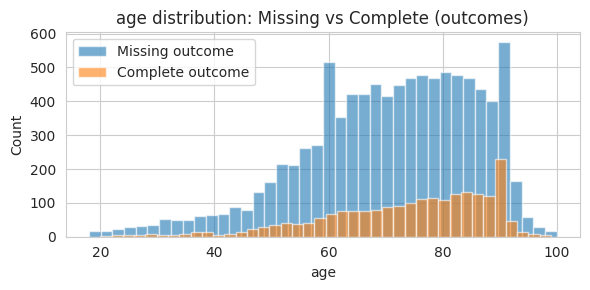

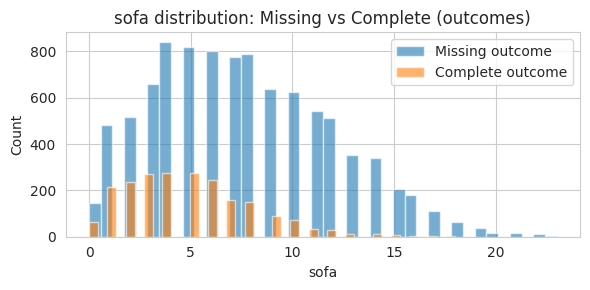

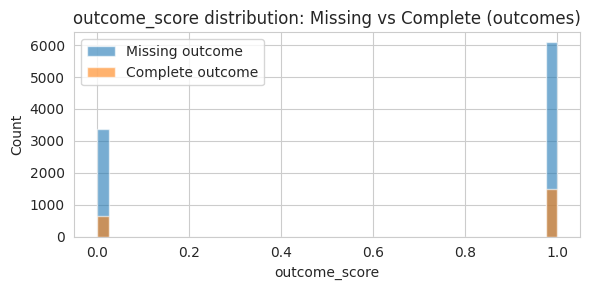

In [161]:
compare_features = ["age", "sofa", "outcome_score"]

for feat in compare_features:
    plt.figure(figsize=(6,3))
    plt.hist(mimic[feat].dropna(), bins=40, alpha=0.6, label="Missing outcome")
    plt.hist(mimic_df[feat].dropna(), bins=40, alpha=0.6, label="Complete outcome")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.title(f"{feat} distribution: Missing vs Complete (outcomes)")
    plt.legend()
    plt.tight_layout()
    plt.show()


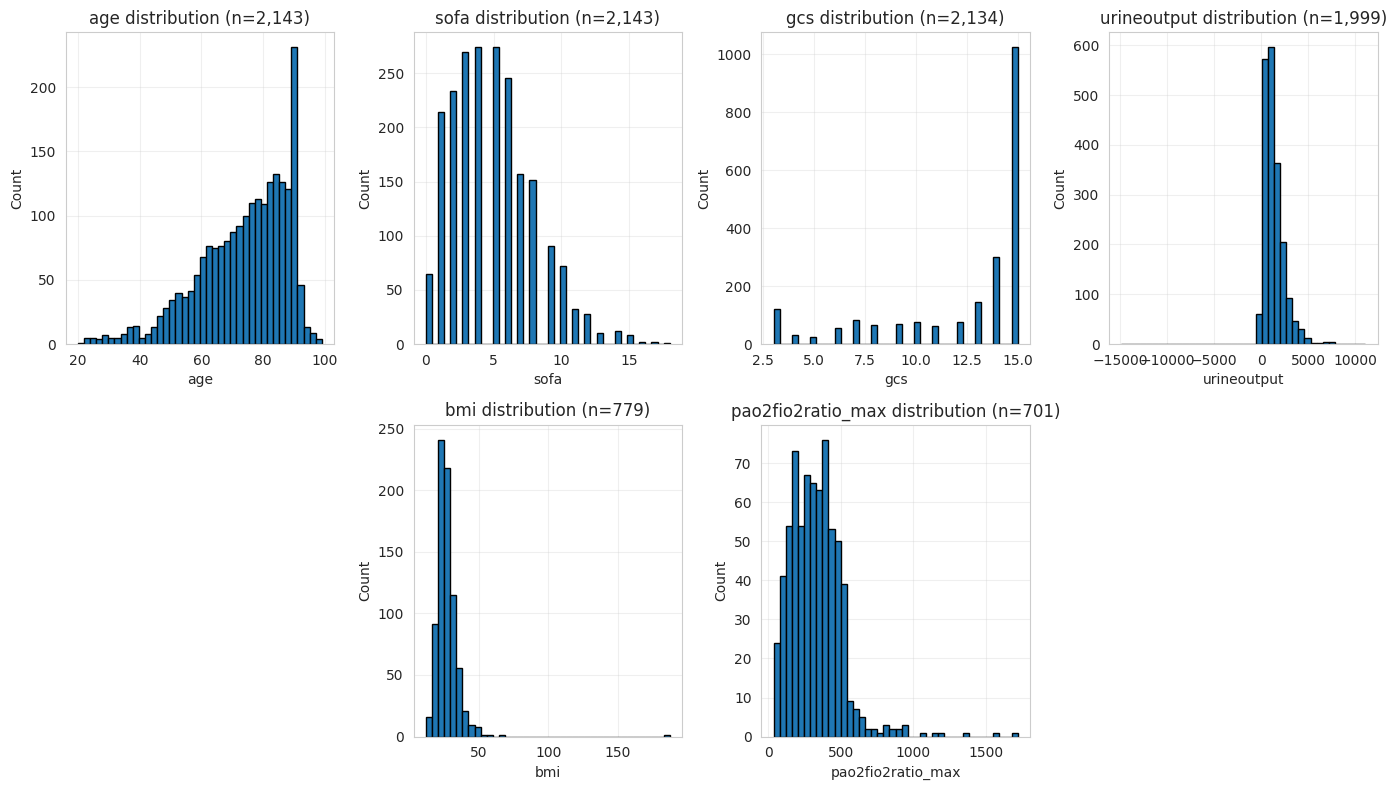

In [162]:
# key physiological features that represent the patient's state -> to show baseline physiological diversity
features = ["age", "sofa", "gcs", "urineoutput", "wbc", "bmi", "pao2fio2ratio_max"]

# Calculate how many rows are needed to display all features
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols)) # np.ceil() rounds up to ensure enough rows even if last one isn't full

# Create a new figure sized proportionally to the number of rows (14 wide, 4 inches tall per row)
plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(features, 1):
    # Loop through all feature names, starting the counter (i) at 1 for subplot indexing
    if col not in mimic_df.columns: # Skip this feature if it's not actually a column in the DataFrame
        continue
    plt.subplot(n_rows, n_cols, i)                        # Create the i-th subplot in a grid of (n_rows × n_cols)
    data = mimic_df[col].dropna()                         # Extract the column’s data, dropping missing values (NaN)
    plt.hist(data, bins=40, edgecolor="black")            # Plot a histogram of the feature using 40 bins, with black edges for clarity
    plt.title(f"{col} distribution (n={len(data):,})")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

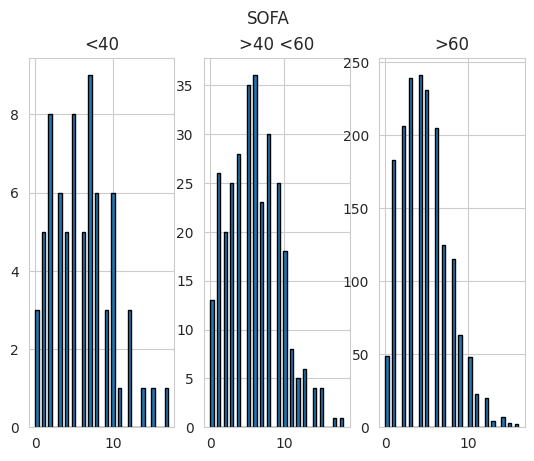

In [163]:
col = "sofa"
data1 = mimic_df[mimic_df["age"] <= 40]
data2 = mimic_df[(mimic_df["age"] > 40) & (mimic_df["age"] <= 60)]
data3 = mimic_df[mimic_df["age"] > 60]
data1 = data1[col].dropna()
data2 = data2[col].dropna()
data3 = data3[col].dropna()

fig, axs = plt.subplots(1, 3)
axs[0].hist(data1, bins=40, edgecolor="black")
axs[0].set_title("<40")
axs[1].hist(data2, bins=40, edgecolor="black")
axs[1].set_title(">40 <60")
axs[2].hist(data3, bins=40, edgecolor="black")
axs[2].set_title(">60")
fig.suptitle("SOFA")
plt.show()

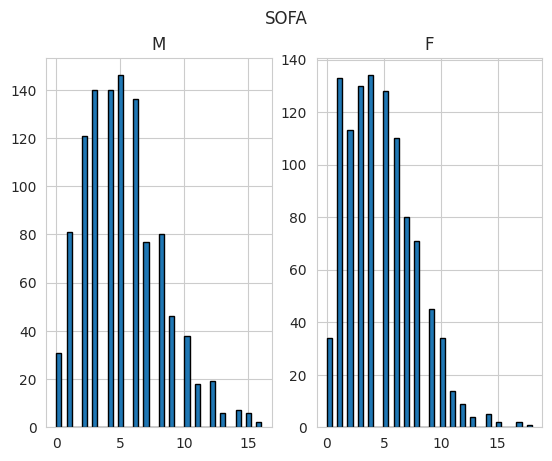

In [164]:
col = "sofa"
data1 = mimic_df[mimic_df["gender"] == "M"]
data2= mimic_df[mimic_df["gender"] == "F"]
data1 = data1[col].dropna()
data2 = data2[col].dropna()

fig, axs = plt.subplots(1, 2)
axs[0].hist(data1, bins=40, edgecolor="black")
axs[0].set_title("M")
axs[1].hist(data2, bins=40, edgecolor="black")
axs[1].set_title("F")
fig.suptitle("SOFA")
plt.show()

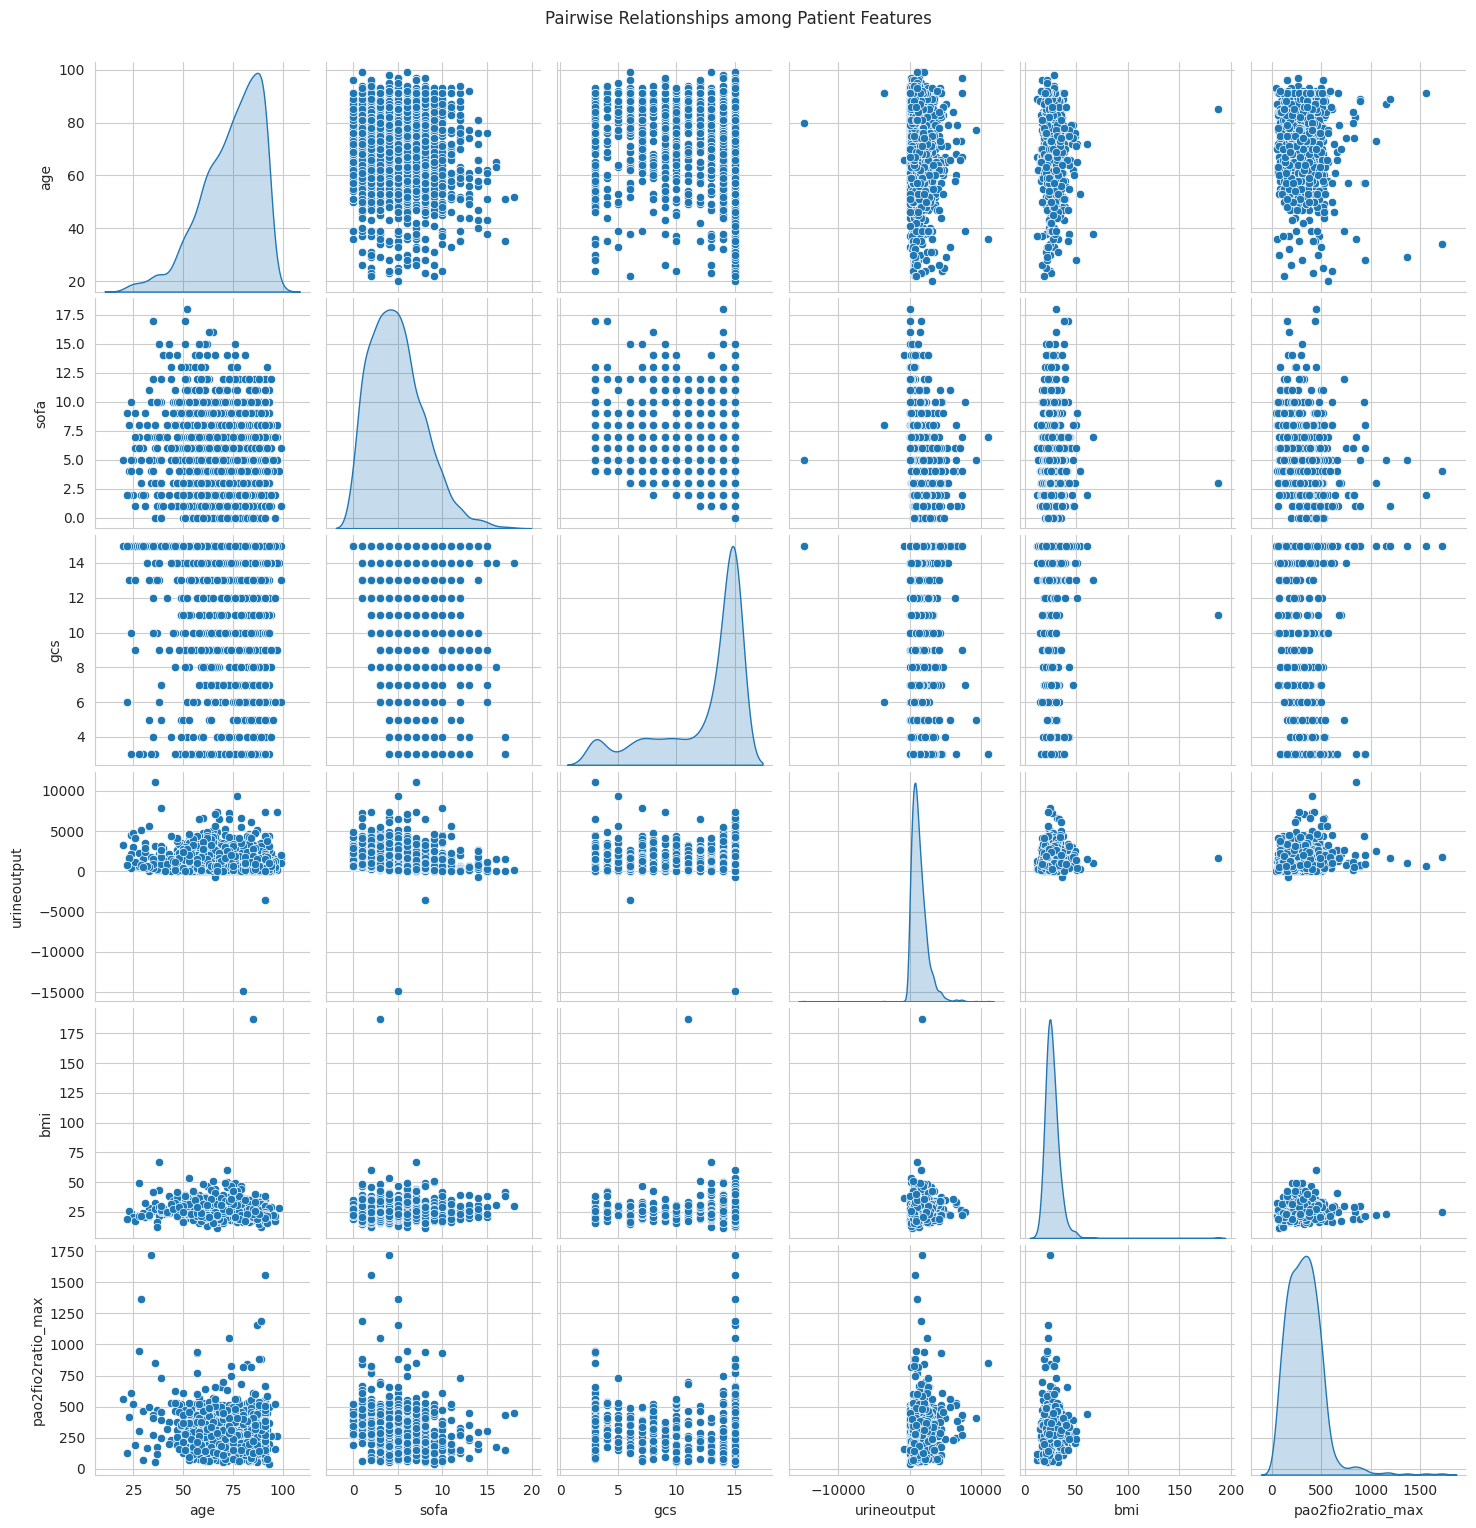

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---- pairplot of key continuous features ----
feat_subset = ["age", "sofa", "gcs", "urineoutput", "bmi", "pao2fio2ratio_max"]
feat_subset = [f for f in feat_subset if f in mimic_df.columns]
sns.pairplot(mimic_df.sample(min(5000, len(mimic_df))), vars=feat_subset, diag_kind="kde") # The diagonal cells show the distribution of each single feature (KDE curves) - kernel density estimate
plt.suptitle("Pairwise Relationships among Patient Features", y=1.02) # Adjusts the vertical position of the title slightly above the figure (by default, it’s at y=1.0).
plt.show()

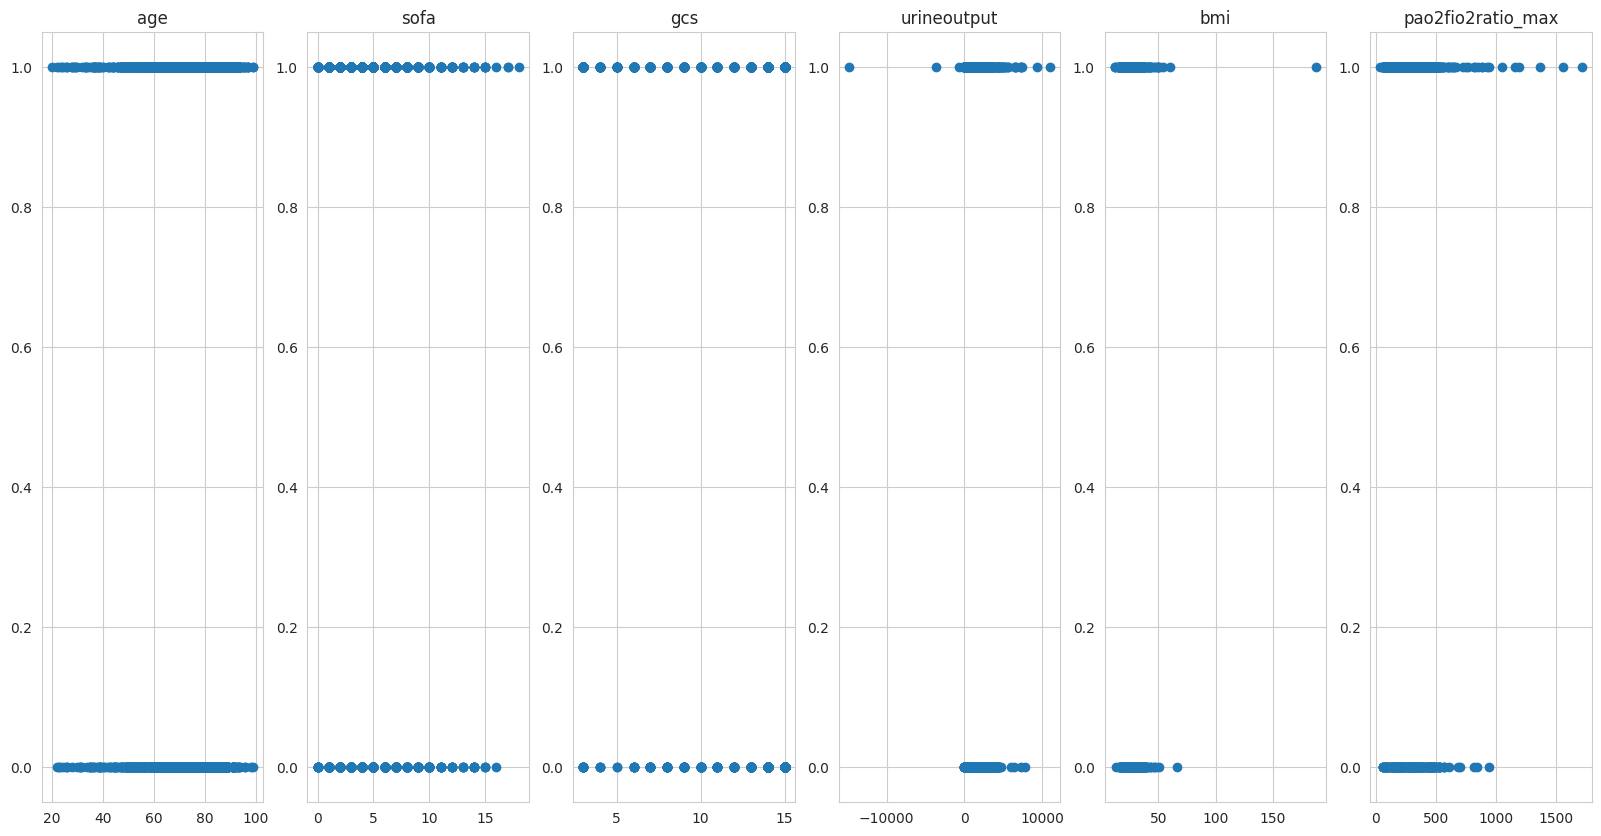

In [166]:
feat_subset = ["age", "sofa", "gcs", "urineoutput", "bmi", "pao2fio2ratio_max"]
fig, axs = plt.subplots(1, len(feat_subset), figsize=(20, 10))
for k, feature_name in enumerate(feat_subset):
  axs[k].scatter(mimic_df[feature_name], mimic_df["outcome_score"])
  axs[k].set_title(feature_name)

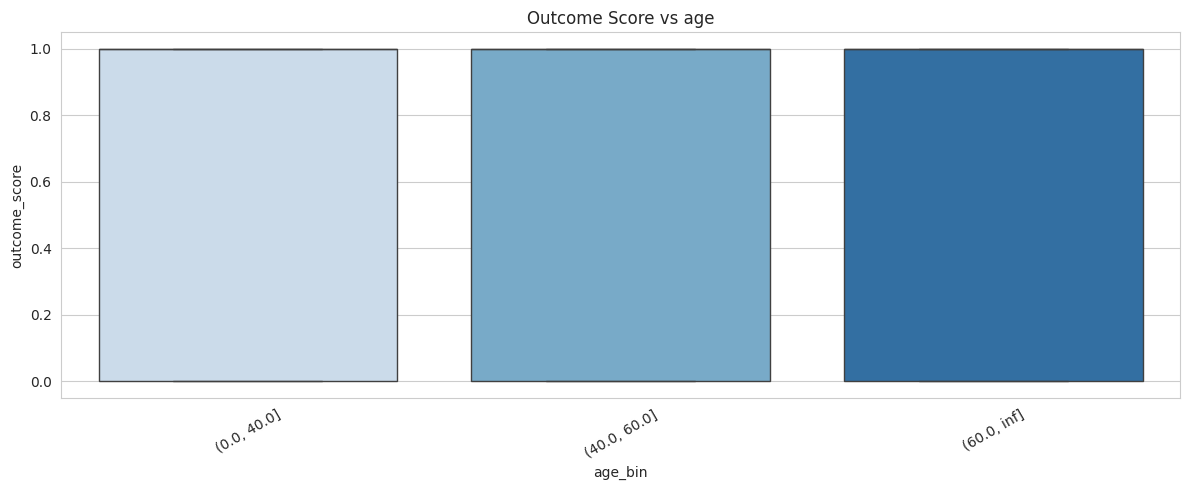

In [167]:
test = mimic_df.copy()
feature = "age"
bins = [0, 40, 60, np.inf]
test[f"{feature}_bin"] = pd.cut(mimic_df[feature], bins=bins)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
sns.boxplot(x=f"{feature}_bin", y="outcome_score", data=test, ax=ax, hue=f"{feature}_bin", palette="Blues", legend = False)
ax.set_title(f"Outcome Score vs {feature}")
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

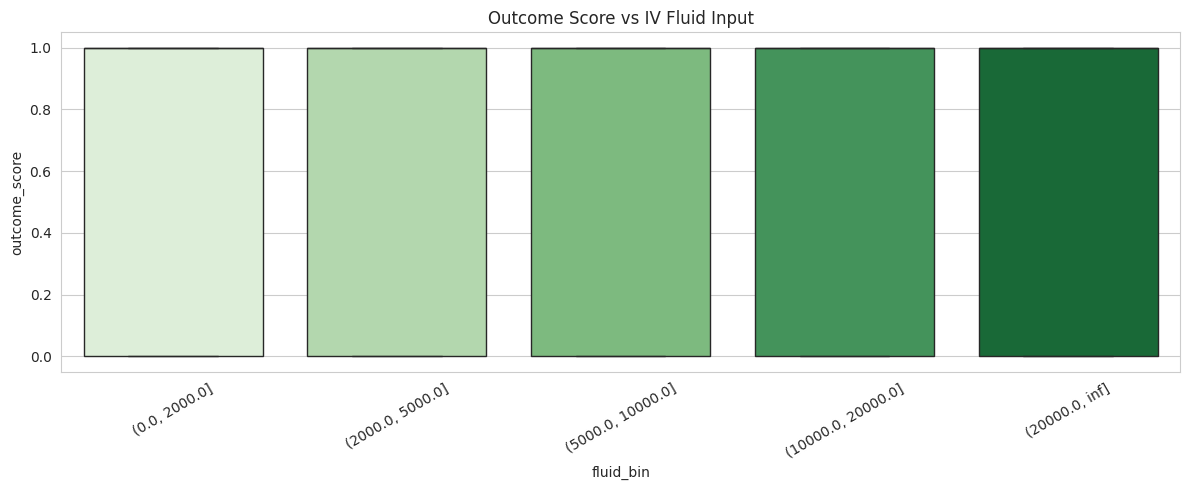

In [168]:
# Define bins for treatments -> Helps compare groups of patients by treatment intensity level rather than raw dosage.
mimic_df["fluid_bin"] = pd.cut(mimic_df["ivf"], bins=[0, 2000, 5000, 10000, 20000, np.inf])

fig, ax = plt.subplots(1, 1, figsize=(12,5))  # 1 row and 2 columns
sns.boxplot(x="fluid_bin", y="outcome_score", data=mimic_df, ax=ax, hue="fluid_bin", palette="Greens", legend=False)
ax.set_title("Outcome Score vs IV Fluid Input")
ax.tick_params(axis='x', rotation=30)# formating in x axis
plt.tight_layout()
plt.show()


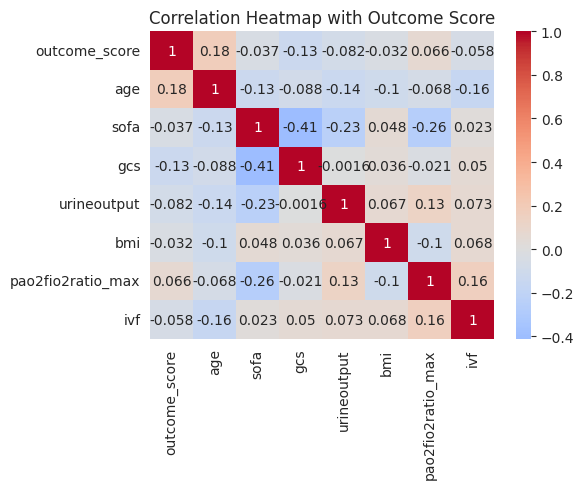

In [169]:
corr = mimic_df[["outcome_score", "age", "sofa", 'gcs', 'urineoutput', 'bmi', 'pao2fio2ratio_max', "ivf"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap with Outcome Score")
plt.tight_layout(); plt.show()


In [170]:
class Filter:
    """
        Simple filter class for propensity matching
        - Filter class is used to define which rows in your dataset (e.g., patients) are similar enough to a given patient (source_row) for matching purposes.
        - Each filter compares one feature (e.g., age, heart rate, lactate level) between:
            - the source value (from the patient you’re matching), and
            - the values in other patients (rows) in the dataset.
        - The “mode”: how to decide whether two values are close enough.
    """

    # Defines a Filter object used to create inclusion criteria for matching rows (e.g., patients)
    def __init__(
        self,
        feature: str,                     # column name to apply the filter on
        mode: str = "absolute",           # determines how the filtering range is calculated ("absolute", "percentage", or "set")
        width: Optional[float] = None,    # used as tolerance (absolute difference or percentage)
        lower: Optional[float] = None,    # explicit numeric limits for "set" mode
        upper: Optional[float] = None,
    ) -> None:
        # Initialize a Filter object with configuration parameters
        self.feature = feature
        self.mode = mode
        self.width = width
        self.lower = lower
        self.upper = upper

    # Given a dataframe and a reference (source) value, return a boolean Series marking which rows of df satisfy this filter condition
    def get_mask(self, df: pd.DataFrame, source_value: float) -> pd.Series:
        """Returns a boolean Series telling which rows pass that filter"""

        if self.mode == "absolute":         # Mode 1: absolute range around the source_value
            return (df[self.feature] >= source_value - self.width) & (
                df[self.feature] <= source_value + self.width
            )
        # Example: width=5 → keep rows where feature is within [value−5, value+5]

        elif self.mode == "percentage":     # Mode 2: percentage-based range around the source_value
            lower = source_value * (1 - self.width / 100)
            upper = source_value * (1 + self.width / 100)
            # If the value is negative, make sure lower/upper are ordered correctly
            if source_value < 0:
                lower, upper = min(lower, upper), max(lower, upper)
            return (df[self.feature] >= lower) & (df[self.feature] <= upper)
            # Example: width=10 → keep rows within ±10% of source_value

        elif self.mode == "set":            # Mode 3: fixed lower and upper range (independent of the source value.)
            return (df[self.feature] >= self.lower) & (df[self.feature] <= self.upper)
            # Example: lower=20, upper=40 → keep rows where 20 ≤ feature ≤ 40

In [171]:
def find_matches(source_row: pd.Series, df: pd.DataFrame, filters: List[Filter]) -> pd.DataFrame:
    """Find matching patients based on filters"""
    mask = pd.Series([True] * len(df), index=df.index)  # Starts with a mask of all True (everyone is a candidate).
    for filt in filters:    # For each Filter, intersect (&=) with its mask → rows must satisfy all filters (AND logic).
        mask &= filt.get_mask(df, source_row[filt.feature])
    mask[source_row.name] = False # Excludes the source row itself.
    return df[mask]               # Returns the subset DataFrame of rule-based matches.

In [172]:
def select_top_neighbors(
    source_row: pd.Series,
    matches_df: pd.DataFrame,
    normalized_df: pd.DataFrame,    # is the entire dataset, but with all numeric features standardized (mean = 0, std = 1) -> This lets you calculate Euclidean distances fairly, because age, lactate, and SOFA all have different scales originally.
    distance_features: List[str],   # the columns used to compute distances.
    n_neighbors: int,               # how many closest to keep.
) -> pd.DataFrame:

    """
        Select closest neighbors
        If there are more matches than you want, it narrows them down by closeness in a pre-normalized space.
        Computes Euclidean distances between the source vector and each candidate, sorts, and returns the top K rows.
        Hard filters remove obviously dissimilar patients before distance is used.
    """
    if len(matches_df) == 0 or len(matches_df) <= n_neighbors:
        return matches_df # If there are no matches, or fewer than the desired number of neighbors, just return them all, no need to compute distances.

    # Extracts the feature vector (e.g., [age, SOFA, lactate, ...]) for the source patient from the normalized dataset.
    source_vec = normalized_df.loc[source_row.name, distance_features].values.reshape(1, -1)

    # Extracts the feature vectors for all candidate matches, again from the normalized dataset, using their indices from matches_df
    match_vecs = normalized_df.loc[matches_df.index, distance_features].values
    # now we have:
        # source_vec: a single 1×N vector
        # match_vecs: an M×N matrix of candidate rows

    distances = euclidean_distances(source_vec, match_vecs)[0]  # Calculates Euclidean distance between the source and every candidate using all selected features (Smaller distance = more similar)
    top_k_idx = np.argsort(distances)[:n_neighbors]             # Sorts candidates by distance and keeps only the closest K.
    return matches_df.iloc[top_k_idx]                           # Returns the subset of matches_df corresponding to those top K neighbors.

In [173]:
filters = [
    Filter("age", mode="absolute", width=5),
    Filter("sofa", mode="absolute", width=2),
    Filter("mechvent", mode="percentage", width=25),
]

distance_features = [
    "age",
    "sofa",
    'gcs',
    'urineoutput',
    'bmi',
    'pao2fio2ratio_max',
]
n_neighbors = 100

In [174]:
# Imput missing values
for key in distance_features:
  mean = np.nanmean(mimic_df[key].to_numpy())
  mimic_df[key] = mimic_df[key].apply(lambda x: mean if np.isnan(x) else x)

In [175]:
scaler = StandardScaler()
mimic_normalized = mimic_df.copy()
mimic_normalized[distance_features] = scaler.fit_transform(mimic_df[distance_features])

In [176]:
def recommend_treatment(
    matches_df: pd.DataFrame,
    action_column: str = "vasopressor_dose",
    outcome_column: str = "outcome_score",
    bins: Optional[List[float]] = None,
    min_support: int = 10,
) -> Dict[str, Optional[float]]:
    """
    Recommend treatment based on actual outcomes of the matched patients

    Args:
        matches_df: Dataframe with matched patients
        action_column: Column name for the treatment action
        outcome_column: Column name for the outcome measure
        bins: Optional list of bins for discretizing the action
        min_support: Minimum number of matches required for a bin to be considered (avoid noise)

    Returns:
        Dict with recommended action, expected outcome, number of matches, and bin stats
    """
    if bins is None:
        # Default bins for vasopressor (norepinephrine) dose (mcg/kg/min)
        bins = [0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 1.0]

    matches_df = matches_df.copy()

    # Added include_lowest=True to ensure patients with dose=0 are included
    matches_df["action_bin"] = pd.cut(
        matches_df[action_column],
        bins=bins,
        labels=[f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)],    # generates human-readable bin labels (like "0.10–0.20") from your list of bin edges, so the output column action_bin shows clear ranges instead of numerical intervals.
        include_lowest=True,  # Include leftmost edge
    )

    # Build aggregation dict based on available columns
    agg_dict = {outcome_column: ["mean", "std", "count"]}   # For each group (each treatment dose bin), calculate the mean, standard deviation, and number of patients for the column outcome_score

    # Add optional outcome columns if they exist
    # If the DataFrame matches_df has an outcome_score column, and the main outcome (outcome_column) is something else (e.g., "sofa_change"),
    # → then also include outcome_score in the summary and take its mean.
    # This prevents duplicating the same column twice.
    if "outcome_score" in matches_df.columns and outcome_column != "outcome_score":
        agg_dict["outcome_score"] = "mean"
    if "sofa_change" in matches_df.columns:
        agg_dict["sofa_change"] = "mean"
    if "lactate_clearance_pct" in matches_df.columns:
        agg_dict["lactate_clearance_pct"] = "mean"

    # Group the patients by action_bin (e.g., dose range) and compute the mean, std, and count of the outcome for each group.
        # Takes your matches_df (the matched patients), groups them by their treatment dose category (action_bin), and then computes summary statistics (like mean, std, count) for each outcome column, as defined in your agg_dict.
    bin_stats = matches_df.groupby("action_bin", observed=False).agg(agg_dict)

    # FORMATTING
    # Flatten multi-level columns
    if isinstance(bin_stats.columns, pd.MultiIndex): # Check if columns are multi-level (hard to work with)
        new_columns = []                # If yes → we’ll rename them into simple, flat column names.

        for col in bin_stats.columns:   # Loop through each (column_name, aggregation_function) pair
            col_name, agg_func = col
            if col_name == outcome_column:
                if agg_func == "mean":
                    new_columns.append("mean_outcome")
                elif agg_func == "std":
                    new_columns.append("std_outcome")
                elif agg_func == "count":
                    new_columns.append("n_matches")
                else:
                    new_columns.append(f"{col_name}_{agg_func}")
            else:
                # For other columns, just use mean_<colname>
                new_columns.append(f"mean_{col_name}")

        bin_stats.columns = new_columns

    bin_stats = bin_stats.reset_index()

    # Select best action with sufficient support
    valid_bins = bin_stats[bin_stats["n_matches"] >= min_support].copy()

    if len(valid_bins) == 0:
        return {
            "recommended_action": None,
            "expected_outcome": None,
            "n_matches": 0,
            "bin_stats": bin_stats,
            "total_matches_used": int(bin_stats["n_matches"].sum()),
        }

    # Find optimal bin based on available outcome
    outcome_col_name = (
        "mean_outcome_score"
        if "mean_outcome_score" in valid_bins.columns
        else "mean_outcome"
    )

    # Remove NaN values before finding optimal bin
    valid_bins_no_nan = valid_bins[valid_bins[outcome_col_name].notna()].copy()

    if len(valid_bins_no_nan) == 0:
        # If all valid bins have NaN outcomes, return no recommendation
        return {
            "recommended_action": None,
            "expected_outcome": None,
            "n_matches": 0,
            "bin_stats": bin_stats,
            "total_matches_used": int(bin_stats["n_matches"].sum()),
        }

    # Minimum outcome_score = better patient outcome
    optimal_bin = valid_bins_no_nan.loc[valid_bins_no_nan[outcome_col_name].idxmin()]

    result = {
        "recommended_action": optimal_bin["action_bin"],
        "expected_outcome": optimal_bin.get(outcome_col_name, None),
        "n_matches": int(optimal_bin["n_matches"]),
        "bin_stats": bin_stats,
        "total_matches_used": int(bin_stats["n_matches"].sum()),  # Track total usage
    }

    # Add optional outcomes if available
    if "mean_sofa_change" in optimal_bin:
        result["expected_sofa_change"] = optimal_bin["mean_sofa_change"]
    if "mean_lactate_clearance_pct" in optimal_bin:
        result["expected_lactate_clearance"] = optimal_bin["mean_lactate_clearance_pct"]

    return result

In [177]:
# Example: Recommend treatment for one patient
patient_id = 9
action_column = "ivf"
outcome_column = "outcome_score"
bins = [0, 3000, 5000, np.inf]
min_support = 5

source_patient = mimic_df.iloc[patient_id]

# Find matches
all_matches = find_matches(source_patient, mimic_df, filters)
top_matches = select_top_neighbors(
    source_patient, all_matches, mimic_normalized, distance_features, n_neighbors
)

if len(top_matches) > 0:
    recommendation = recommend_treatment(
        top_matches, action_column, outcome_column, bins, min_support
    )

    print("\n" + "=" * 70)
    print("TREATMENT RECOMMENDATION")
    print("=" * 70)
    print(f"\nSource Patient (ID={patient_id}):")
    print(f"  Age: {source_patient['age']:.0f} years")
    print(f"  Baseline SOFA: {source_patient['sofa']:.0f}")
    print(f"  GCS: {source_patient['gcs']:.0f}")
    print(f"  Urine Output: {source_patient['urineoutput']:.0f}")
    print(f"  BMI: {source_patient['bmi']}")
    print(f"  Pao2-fio2 ratio (Max): {source_patient['pao2fio2ratio_max']}")
    print("")
    print(f"  Mechanically Ventilated: {source_patient['mechvent']:.0f}")
    print(f"  Gender: {source_patient['gender']}")
    print(f"  Admission Type: {source_patient['admission_type']}")
    print(f"  Insurance: {source_patient['insurance']}")
    print(f"  Language: {source_patient['language']}")
    print(f"  Marital Status: {source_patient['marital_status']}")
    print(f"  Race: {source_patient['race']}")
    print(f"  Height: {source_patient['height']}")
    print(f"  Weight: {source_patient['first_day_weight']}")
    print("")
    print(f"  Current iv fluid input: {source_patient['ivf']:.3f}mL")

    print(f"\nMatched {len(all_matches)} similar patients from filters")
    print(f"Matched {len(top_matches)} similar patients from top neighbors")

    # Show how many patients were actually used
    if "total_matches_used" in recommendation:
        print(
            f"Using {recommendation['total_matches_used']} out of {len(top_matches)} matched patients in recommendation"
        )

    if recommendation["recommended_action"] is not None:
        print(f"\n" + "-" * 70)
        print(f"Recommended dose: {recommendation['recommended_action']} ml")
        print(f"-" * 70)
        print(
            f"Expected outcomes (based on {recommendation['n_matches']} similar patients):"
        )
        print(f"  - Composite outcome score: {recommendation['expected_outcome']:.2f}")
        if "expected_sofa_change" in recommendation:
            print(
                f"  - SOFA change: {recommendation['expected_sofa_change']:.2f} (negative=improvement)"
            )
        if "expected_lactate_clearance" in recommendation:
            print(
                f"  - Lactate clearance: {recommendation['expected_lactate_clearance']:.1f}%"
            )

        print(f"\nAll treatment options:")
        display(recommendation["bin_stats"])
    else:
        print("\nInsufficient matches for recommendation.")
else:
    print(f"No matches found for patient {patient_id}")


TREATMENT RECOMMENDATION

Source Patient (ID=9):
  Age: 83 years
  Baseline SOFA: 5
  GCS: 15
  Urine Output: 727
  BMI: 20.0
  Pao2-fio2 ratio (Max): 326.98175473979353

  Mechanically Ventilated: 1
  Gender: F
  Admission Type: URGENT
  Insurance: Medicare
  Language: English
  Marital Status: MARRIED
  Race: WHITE - OTHER EUROPEAN
  Height: 150.0
  Weight: 45.0

  Current iv fluid input: 2678.233mL

Matched 135 similar patients from filters
Matched 100 similar patients from top neighbors
Using 100 out of 100 matched patients in recommendation

----------------------------------------------------------------------
Recommended dose: 5000.00-inf ml
----------------------------------------------------------------------
Expected outcomes (based on 32 similar patients):
  - Composite outcome score: 0.69

All treatment options:


,action_bin,mean_outcome,std_outcome,n_matches
0,0.00-3000.00,0.872340,0.337318,47
1,3000.00-5000.00,0.761905,0.436436,21
2,5000.00-inf,0.687500,0.470929,32


In [178]:
def process_patient(
    patient_id: int,
    df: pd.DataFrame,
    normalized_df: pd.DataFrame,
    filters: List[Filter],
    n_neighbors: int,
    action_column: str = "vasopressor_dose",
    outcome_column: str = "outcome_score",
    bins: Optional[List[float]] = None,
    min_support: int = 10,
) -> Optional[Dict[str, Optional[float]]]:
    """Process a single patient and return recommendation results

    Args:
        patient_id: Index of the patient in the dataframe
        df: Original dataframe
        normalized_df: Normalized dataframe for distance calculations
        filters: List of Filter objects for matching
        n_neighbors: Number of neighbors to select
        action_column: Column name for treatment action
        outcome_column: Column name for outcome measure
        bins: Optional list of bins for discretizing the action
        min_support: Minimum number of matches required for a bin to be considered

    Returns:
        Dict with recommendation results or None if no recommendation"""
    source_patient = df.iloc[patient_id]
    all_matches = find_matches(source_patient, df, filters)

    if len(all_matches) == 0:
        return None

    top_matches = select_top_neighbors(
        source_patient, all_matches, normalized_df, distance_features, n_neighbors
    )
    recommendation = recommend_treatment(top_matches, action_column, outcome_column, bins, min_support)
    # recommendation = recommend_treatment_median(top_matches, action_column, outcome_column, bins, min_support)

    if recommendation["recommended_action"] is None:
        return None

    result = {
        "patient_id": patient_id,
        "age": source_patient["age"],
        "baseline_sofa": source_patient["sofa"],
        # "lactate": source_patient["arterial_lactate"],
        # "current_dose": source_patient["vasopressor_dose"],
        "current_dose": source_patient["ivf"],
        "current_outcome": source_patient["outcome_score"],
        "recommended_action": recommendation["recommended_action"],
        "expected_outcome": recommendation["expected_outcome"],
        "n_matches": recommendation["n_matches"],
    }

    return result

In [150]:
# Process a sample of patients
n_neighbors = 1000
n_patients_to_process = 3000
action_column = "ivf"
min_support = 5
bins = [0, 3000, 5000, np.inf]

n_patients_to_process = min(n_patients_to_process, len(mimic_df))
results = []
print(f"Processing {n_patients_to_process} patients...")
for i in tqdm(range(n_patients_to_process)):
    result = process_patient(i, mimic_df, mimic_normalized, filters, n_neighbors, action_column=action_column, bins=bins, min_support=min_support)
    if result is not None:
        results.append(result)

results_df = pd.DataFrame(results)
print(f"\nSuccessfully processed {len(results_df)} patients with recommendations")

Processing 2143 patients...


  0%|          | 0/2143 [00:00<?, ?it/s]


Successfully processed 2071 patients with recommendations


In [151]:
1932

1932

In [152]:
if len(results_df) > 0:
    # NEGATIVE AS WE WANT TO MINIMIZE OUTCOME (MORTALITY)
    results_df["outcome_improvement"] = -1.0 * (
        results_df["expected_outcome"] - results_df["current_outcome"]
    )

    # Add column to check if current dose matches recommendation
    def dose_matches_recommendation(row: pd.Series) -> bool:
        """Check if current dose falls within recommended action bin

        Uses same logic as pd.cut with include_lowest=True:
        - First bin: [lower, upper] (closed on both sides)
        - Other bins: (lower, upper] (left-open, right-closed)
        """
        try:
            # Parse recommended action bin (e.g., "0.00-0.05")
            bin_str = str(row["recommended_action"])
            lower, upper = map(float, bin_str.split("-"))
            current = row["current_dose"]

            # Check if this is the first bin (leftmost)
            is_first_bin = lower == 0.0  # Assuming bins start at 0

            if is_first_bin:
                # First bin: closed on both sides [lower, upper]
                return lower <= current <= upper
            else:
                # Other bins: left-open, right-closed (lower, upper]
                return lower < current <= upper
        except:
            return False

    results_df["dose_matches_rec"] = results_df.apply(
        dose_matches_recommendation, axis=1
    )

    print("\n" + "=" * 70)
    print(f"BATCH PROCESSING RESULTS: {len(results_df)} patients")
    print("=" * 70)

    # FIX: Separate analysis for patients already on recommended dose vs those needing change
    patients_on_rec_dose = results_df[results_df["dose_matches_rec"]]
    patients_need_change = results_df[~results_df["dose_matches_rec"]]

    n_on_rec_dose = len(patients_on_rec_dose)
    n_need_change = len(patients_need_change)

    # Count improvements only among those who need dose changes
    n_would_improve_from_change = (
        patients_need_change["outcome_improvement"] > 0
    ).sum()
    mean_improvement_from_change = patients_need_change["outcome_improvement"].mean()

    print(
        f"\nPatients already on recommended dose: {n_on_rec_dose} ({100*n_on_rec_dose/len(results_df):.1f}%)"
    )
    print(
        f"Patients who would benefit from dose change: {n_need_change} ({100*n_need_change/len(results_df):.1f}%)"
    )

    if n_need_change > 0:
        print(
            f"  - Of those needing change, {n_would_improve_from_change} would see a strictly positive outcome improvement ({100*n_would_improve_from_change/n_need_change:.1f}%)"
        )
        print(
            f"  - Mean expected outcome improvement for those needing change: {mean_improvement_from_change:.2f}"
        )

    # Overall statistics (for completeness)
    print(f"\nOverall statistics:")
    print(
        f"  - Total patients with positive outcome improvement: {(results_df['outcome_improvement'] > 0).sum()} ({100*(results_df['outcome_improvement'] > 0).mean():.1f}%)"
    )
    print(
        f"  - Mean expected outcome improvement (all patients): {results_df['outcome_improvement'].mean():.2f}"
    )
    print(
        f"  - Mean number of matches per patient: {results_df['n_matches'].mean():.0f}"
    )

    print("\nSample recommendations:")
    display_cols = [
        "patient_id",
        "current_dose",
        "recommended_action",
        "dose_matches_rec",
        "outcome_improvement",
    ]
    display(results_df[display_cols].head(10))
else:
    print("No patients could be processed with sufficient matches.")


BATCH PROCESSING RESULTS: 2071 patients

Patients already on recommended dose: 644 (31.1%)
Patients who would benefit from dose change: 1427 (68.9%)
  - Of those needing change, 1008 would see a strictly positive outcome improvement (70.6%)
  - Mean expected outcome improvement for those needing change: 0.08

Overall statistics:
  - Total patients with positive outcome improvement: 1459 (70.4%)
  - Mean expected outcome improvement (all patients): 0.08
  - Mean number of matches per patient: 38

Sample recommendations:


,patient_id,current_dose,recommended_action,dose_matches_rec,outcome_improvement
0,0,5096.329764,5000.00-inf,True,-0.714286
1,1,29092.967832,3000.00-5000.00,False,-0.500000
2,2,9125.104102,5000.00-inf,True,-0.684211
3,3,9660.933501,5000.00-inf,True,0.400000
4,4,1149.999996,0.00-3000.00,True,-0.542857
5,5,1069.500010,5000.00-inf,False,0.363636
6,6,7754.094534,3000.00-5000.00,False,-0.622222
7,7,1100.999967,3000.00-5000.00,False,0.357143
8,8,12610.589792,3000.00-5000.00,False,-0.696970
9,9,2678.233339,5000.00-inf,False,0.300000
